<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Sentiment Analysis of Movie Reviews With SpaCy and VADER

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Understand the goal of basic sentiment analysis.
- Calculate sentiment scores manually using a movie reviews data set and scores tagged by word.
- Practice using the spaCy parser to distill part-of-speech tags from text.
- Fit a model using sentiment and grammar features.
- Use the VADER sentiment analyzer to get more accurate sentiment scores and compare the models.

### Lesson Guide
- [Introduction to Sentiment Analysis](#intro)
- [Load the Word Sentiment Data Set](#load-sen)
    - [Engineer Objectivity and Positive Difference Scores](#adj-scores)
    - [Put Scores in a Parts-of-Speech Dictionary](#pos-dict)
- [Load the Rotten Tomatoes Review Data Set](#rt-reviews)
    - [Restrict Reviews to Valid Lengths and Ratings](#subset)
- [Import SpaCy](#spacy)
    - [Parse All of the Quotes Using SpaCy's Multithreaded Parser](#multi)
- [Parts-of-Speech Features](#pos-features)
- [Assign Sentiment Scores](#assign)
- [Print Out the Most Positive and Negative Reviews](#print-most)
- [Print Out the Most Objective and Subjective Reviews](#print-most-obj)
- [Build a Model to Classify Fresh vs. Rotten With the Sentiment and Grammar Features](#model)
- [Use the VADER Library to Get Better Sentiment Scores](#vader)
    - [Build a Model Using the VADER Sentiment Features](#vader-model)

<a id='intro'></a>

## Introduction to Sentiment Analysis
---

Sentiment analysis is one of the most popular topics in NLP. Most commonly, it's the quantification of text into valence and subjectivity scores.

First, we'll load in a data set of precoded sentiment scores for positivity and negativity of words. These words are also tagged with their part of speech in the sentence. We can use these valence scores to evaluate the sentiment of Rotten Tomatoes movie reviews. Many packages, such as TextBlob, come prepackaged with sentiment scores for words after parsing text. But doing the sentiment parsing manually will show you how it can be done without any "magic."

We'll also explore a more advanced sentiment analysis library in Python: [VADER](https://github.com/cjhutto/vaderSentiment). We can parse the sentiment of the movie reviews using this package and compare it to our more basic method.


<a id='load-sen'></a>

## Load the Word Sentiment Data Set
---

Below, we’ll load in some pre-tagged positive and negative valence scores for a dictionary of words. Each row of the data set contains the part of speech, the word, and the positive and negative scores for the word. A word may appear more than once if it can be classified with different parts-of-speech tags. 

These scores are designed so we can also derive the *objectivity score* of the word from the positive and negative scores.

Objectivity is calculated as: 

    1. - (positive_score + negative_score)

If a score has a zero positive and negative score, it’s completely objective. If a score has, for example, a 0.5 positive and 0.5 negative score, it may not be any more positive than negative, but we can tell that it's subjective.


In [1]:
import pandas as pd
import numpy as np

In [2]:
sen = pd.read_csv('./datasets/sentiment_words_simple.csv')

In [3]:
# A:

sen.head()

,pos,word,pos_score,neg_score
0,adj,.22-caliber,0.0,0.0
1,adj,.22-calibre,0.0,0.0
2,adj,.22_caliber,0.0,0.0
3,adj,.22_calibre,0.0,0.0
4,adj,.38-caliber,0.0,0.0


**Make the parts-of-speech tags uppercase (this will come in handy when we use spaCy).**

In [4]:
sen['pos'] = sen['pos'].str.upper()
sen.head()

,pos,word,pos_score,neg_score
0,ADJ,.22-caliber,0.0,0.0
1,ADJ,.22-calibre,0.0,0.0
2,ADJ,.22_caliber,0.0,0.0
3,ADJ,.22_calibre,0.0,0.0
4,ADJ,.38-caliber,0.0,0.0


<a id='adj-scores'></a>

### Engineer Objectivity and Positive Difference Scores

Because subjective versus objective is embedded in the positive and negative scores, we should extract this and convert the scores into relative difference scores.

**Calculate two new scores:**

    objectivity = 1. - (pos_score + neg_score)
    pos_vs_neg = pos_score - neg_score
    

In [5]:
sen['objectivity'] = 1. - (sen['pos_score'] + sen['neg_score'])
sen['pos_vs_neg'] = sen['pos_score'] - sen['neg_score']

In [6]:
sen.head()

,pos,word,pos_score,neg_score,objectivity,pos_vs_neg
0,ADJ,.22-caliber,0.0,0.0,1.0,0.0
1,ADJ,.22-calibre,0.0,0.0,1.0,0.0
2,ADJ,.22_caliber,0.0,0.0,1.0,0.0
3,ADJ,.22_calibre,0.0,0.0,1.0,0.0
4,ADJ,.38-caliber,0.0,0.0,1.0,0.0


<a id='pos-dict'></a>

### Put Scores in a Parts-of-Speech Dictionary

The dictionary format of the data will be much easier to index using our parsing functions later on. Create a dictionary where the keys are the four parts-of-speech tags:

    ADJ
    NOUN
    VERB
    ADV

For each key, store a dictionary that contains all of the words for that part of speech with their objectivity and positive versus negative scores.

In [7]:
ADJ_dict = {}
ADJ_dict['word'] = {'objectivity':7, 'pos_vs_neg':5}

In [8]:
ADJ_dict

{'word': {'objectivity': 7, 'pos_vs_neg': 5}}

In [9]:
ADJ = sen[sen['pos']=='ADJ']
NOUN = sen[sen['pos']=='NOUN']
VERB = sen[sen['pos']=='VERB']
ADV = sen[sen['pos']=='ADV']

In [10]:
ADJ_dict = {}
NOUN_dict = {}
VERB_dict = {}
ADV_dict = {}
for index, row in ADJ.iterrows():
    ADJ_dict[row['word']] = {'objectivity':row['objectivity'], 'pos_vs_neg':row['pos_vs_neg']}
for index, row in NOUN.iterrows():
    NOUN_dict[row['word']] = {'objectivity':row['objectivity'], 'pos_vs_neg':row['pos_vs_neg']}
for index, row in VERB.iterrows():
    VERB_dict[row['word']] = {'objectivity':row['objectivity'], 'pos_vs_neg':row['pos_vs_neg']}
for index, row in ADV.iterrows():
    ADV_dict[row['word']] = {'objectivity':row['objectivity'], 'pos_vs_neg':row['pos_vs_neg']}

<a id='rt-reviews'></a>

## Load the Rotten Tomatoes Reviews Data Set

---

This data set has:
    
    critic: Critic's name.
    fresh: Fresh vs. rotten rating.
    imdb: Code for IMDB.
    publication: Where the review was published.
    quote: The review snippet.
    review_date: Date of review.
    rtid: Rotten Tomatoes ID.
    title: Name of movie.

In [119]:
rt = pd.read_csv('./datasets/rt_critics.csv')

In [120]:
rt.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story
1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story
2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story
3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story
4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story


<a id='subset'></a>

### Restrict Data to Reviews With Valid Ratings and Reviews More Than 10 Words Long

Additionally, clean up the reviews, making a column with the case and punctuation removed.

In [121]:
rt['fresh'].value_counts()

fresh     8613
rotten    5436
none        23
Name: fresh, dtype: int64

In [122]:
rt['quote_len'] = rt['quote'].map(lambda x: len(x))

In [123]:
import string
rt['qt'] = rt['quote'].map(lambda x: x.translate(None, string.punctuation).lower())

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

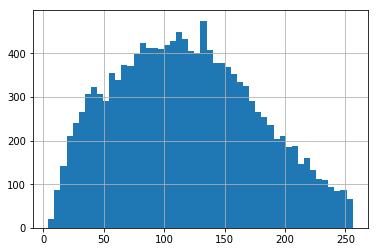

In [125]:
rt['quote_len'].hist(bins=50)

In [126]:
rt = rt[(rt['fresh'] != 'none') & (rt['quote_len']>10)]

In [132]:
len(rt)

14010

<a id='spacy'></a>

## Import SpaCy

---

The spaCy package is the current gold standard for parsing the grammatical structure of text (aside from neural network architectures). We're going to use it to find the parts-of-speech tags for the review words. 

Once we’ve parsed the tags with spaCy, we can assign objectivity and valence scores by finding the match in our sentiment data set.

The code for loading spaCy is:

- ```pip install spaCy```
- ```Python -m spaCy download en```

In [2]:
import spacy
en_nlp = spacy.load('en_core_web_sm')

**Parse a single quote.**

In [3]:
# A:
rt.qt = rt.qt.astype('unicode')
tmp = en_nlp(rt.qt.values[0])
tmp

NameError: name 'rt' is not defined

In [ ]:
len(tmp)

**Print out the parts-of-speech tags for each word in the quote.**

In [ ]:
for token in tmp:
    print(token, token.pos_)

<a id='multi'></a>
### Parse All of the Quotes Using SpaCy's Multithreaded Parser

Parsing a lot of text can take awhile. Luckily, spaCy comes with multithreading functionality to speed up the process. Below is code that will parse the quotes across multiple threads and assign them to a list.

In [107]:
parsed_quotes = []
for i, parsed in enumerate(en_nlp.pipe(rt.qt.values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print i
    parsed_quotes.append(parsed)  

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


<a id='pos-features'></a>

## Create Features With Parts-of-Speech Proportions

---

With our spaCy-parsed reviews, we have a lot of feature engineering potential before we even get to sentiment. Something simple we could do is calculate the proportion of words in the quote that have each part-of-speech tag. We can try using these as predictors later.

**Find all of the unique part-of-speech categories in the reviews.**

In [166]:
pos = []
for quote in parsed_quotes:
    for token in quote:
        pos.append(token.pos_)
uniq_pos = set(pos)

In [228]:
uniq_pos

{u'ADJ',
 u'ADP',
 u'ADV',
 u'CCONJ',
 u'DET',
 u'INTJ',
 u'NOUN',
 u'NUM',
 u'PART',
 u'PRON',
 u'PROPN',
 u'PUNCT',
 u'SPACE',
 u'SYM',
 u'VERB',
 u'X'}

In [109]:
tokens_pos = []
for token in parsed_quotes[0]:
    tokens_pos.append(token.pos_)
pos_ct = {}
for i, e in enumerate(uniq_pos):
    pos_ct[e] = tokens_pos.count(e)

In [1]:
pos_ct

NameError: name 'pos_ct' is not defined

In [110]:
pos_cts = []
for quote in parsed_quotes:
    tokens_pos = []
    for token in quote:
        tokens_pos.append(token.pos_)
    pos_ct = {}
    for i, e in enumerate(uniq_pos):
        pos_ct[e] = tokens_pos.count(e)
    pos_cts.append(pos_ct)

In [111]:
pos_df = pd.DataFrame(pos_cts)

In [229]:
pos_df.head()

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
0,2,4,2,2,1,0,6,0,0,2,0,0,0,0,5,0
1,1,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0
2,1,2,0,0,2,0,5,0,0,0,0,0,0,0,3,0
3,3,1,0,1,5,0,5,0,0,0,0,0,0,0,3,0
4,2,1,1,0,2,0,6,1,0,0,0,0,0,0,2,0


In [136]:
print len(rt)
print len(pos_df)

14010
14010


In [139]:
df = pd.concat([rt.reset_index(), pos_df], axis=1)

**Create the proportion columns for each part of speech.**

In [147]:
prop_cols = []
for uniq in uniq_pos:
    prop_cols.append(uniq+'_%')

In [151]:
len(parsed_quotes[0])

24

In [162]:
df['parsed_quotes'] = parsed_quotes
df['p_qt_len'] = rt['parsed_quotes'].map(lambda x: len(x))
df

,index,critic,fresh,imdb,publication,quote,review_date,rtid,title,quote_len,...,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X,parsed_quotes,p_qt_len
0,0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story,137,...,0,2,0,0,0,0,5,0,"(so, ingenious, in, concept, design, and, exec...",24.0
1,1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story,33,...,0,0,0,0,0,0,0,0,"(the, years, most, inventive, comedy)",5.0
2,2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story,79,...,0,0,0,0,0,0,3,0,"(a, winning, animated, feature, that, has, som...",13.0
3,3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story,107,...,0,0,0,0,0,0,3,0,"(the, film, sports, a, provocative, and, appea...",18.0
4,4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story,110,...,0,0,0,0,0,0,2,0,"(an, entertaining, computergenerated, hyperrea...",15.0
5,5,Michael Booth,fresh,114709.0,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559.0,Toy story,238,...,1,1,0,0,0,0,6,0,"(as, lion, king, did, before, it, toy, story, ...",41.0
6,6,Geoff Andrew,fresh,114709.0,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559.0,Toy story,185,...,0,0,0,0,0,0,8,0,"(the, film, will, probably, be, more, fully, a...",28.0
7,7,Janet Maslin,fresh,114709.0,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559.0,Toy story,156,...,0,0,0,0,0,0,5,0,"(children, will, enjoy, a, new, take, on, the,...",26.0
8,8,Kenneth Turan,fresh,114709.0,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559.0,Toy story,187,...,0,0,0,0,0,0,6,0,"(although, its, computergenerated, imagery, is...",30.0
9,9,Susan Wloszczyna,fresh,114709.0,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559.0,Toy story,113,...,0,0,0,0,0,0,1,0,"(how, perfect, that, two, of, the, most, popul...",21.0


In [180]:
for col in df.loc[:,'ADJ':'X'].columns:
    df[col+'_%'] = df[col]/df['p_qt_len']*100

In [181]:
df.head()

,index,critic,fresh,imdb,publication,quote,review_date,rtid,title,quote_len,...,NOUN_%,NUM_%,PART_%,PRON_%,PROPN_%,PUNCT_%,SPACE_%,SYM_%,VERB_%,X_%
0,0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story,137,...,25.000000,0.000000,0.0,8.333333,0.0,0.0,0.0,0.0,20.833333,0.0
1,1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story,33,...,40.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story,79,...,38.461538,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,23.076923,0.0
3,3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story,107,...,27.777778,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,16.666667,0.0
4,4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story,110,...,40.000000,6.666667,0.0,0.000000,0.0,0.0,0.0,0.0,13.333333,0.0


**Iterate through the reviews and calculate the proportions of each part-of-speech tag.**

In [104]:
# A:

<a id='assign'></a>

## Assign Sentiment Scores
---

We'll now use the parsed reviews and the sentiment data set to assign the average objectivity and positive versus negative scores.

If a word can't be found in the data set, we can ignore it. If a review has no words that match something in our data set, we can assign overall neutral scores of `objectivity = 1` and `pos_vs_neg = 0`.

There are problems with this approach, but for now we can keep it simple and see if things improve when we use the VADER analyzer.

In [184]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['quote'].map(lambda x: analyzer.polarity_scores(x))

In [191]:
sentiment = {}
for i, row in df.iterrows():
    sentiment[i] = analyzer.polarity_scores(row['quote'])
sent_df = pd.DataFrame(sentiment).T

In [197]:
df = pd.concat([df, sent_df], axis=1)

In [231]:
df

,index,critic,fresh,imdb,publication,quote,review_date,rtid,title,quote_len,...,PUNCT_%,SPACE_%,SYM_%,VERB_%,X_%,sentiment,compound,neg,neu,pos
0,0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story,137,...,0.0,0.000000,0.0,20.833333,0.0,"{u'neg': 0.0, u'neu': 0.891, u'pos': 0.109, u'...",0.4019,0.000,0.891,0.109
1,1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story,33,...,0.0,0.000000,0.0,0.000000,0.0,"{u'neg': 0.0, u'neu': 0.59, u'pos': 0.41, u'co...",0.4173,0.000,0.590,0.410
2,2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story,79,...,0.0,0.000000,0.0,23.076923,0.0,"{u'neg': 0.0, u'neu': 0.764, u'pos': 0.236, u'...",0.5267,0.000,0.764,0.236
3,3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story,107,...,0.0,0.000000,0.0,16.666667,0.0,"{u'neg': 0.0, u'neu': 1.0, u'pos': 0.0, u'comp...",0.0000,0.000,1.000,0.000
4,4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story,110,...,0.0,0.000000,0.0,13.333333,0.0,"{u'neg': 0.0, u'neu': 0.805, u'pos': 0.195, u'...",0.4404,0.000,0.805,0.195
5,5,Michael Booth,fresh,114709.0,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559.0,Toy story,238,...,0.0,0.000000,0.0,14.634146,0.0,"{u'neg': 0.0, u'neu': 0.839, u'pos': 0.161, u'...",0.6908,0.000,0.839,0.161
6,6,Geoff Andrew,fresh,114709.0,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559.0,Toy story,185,...,0.0,0.000000,0.0,28.571429,0.0,"{u'neg': 0.0, u'neu': 0.756, u'pos': 0.244, u'...",0.8431,0.000,0.756,0.244
7,7,Janet Maslin,fresh,114709.0,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559.0,Toy story,156,...,0.0,0.000000,0.0,19.230769,0.0,"{u'neg': 0.0, u'neu': 0.616, u'pos': 0.384, u'...",0.9099,0.000,0.616,0.384
8,8,Kenneth Turan,fresh,114709.0,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559.0,Toy story,187,...,0.0,0.000000,0.0,20.000000,0.0,"{u'neg': 0.0, u'neu': 0.683, u'pos': 0.317, u'...",0.8910,0.000,0.683,0.317
9,9,Susan Wloszczyna,fresh,114709.0,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559.0,Toy story,113,...,0.0,0.000000,0.0,4.761905,0.0,"{u'neg': 0.0, u'neu': 0.644, u'pos': 0.356, u'...",0.8742,0.000,0.644,0.356


<a id='print-most'></a>
## Print Out the Most Positive and Negative Reviews
---

Now that we have the average valence for reviews, try printing out the top 10 most positive and top 10 most negative reviews to visually verify that our approach makes sense.

In [216]:
#top 10 negative
print df.sort_values(['compound'])['quote'].head(10).values

['I hated this movie. Hated hated hated hated hated this movie. Hated it.'
 "Both a terrifying, grim look at battle and an excruciatingly tense courtroom thriller. Together, it's a devastating indictment of war as conducted by opportunists and liars."
 'The movie has never really been about gold but about character, and Bogart fearlessly makes Fred C. Dobbs into a pathetic, frightened, selfish man -- so sick we would be tempted to pity him, if he were not so undeserving of pity.'
 'A disaster film with an exceedingly witty premise. Instead of a terrorist, volcano, or extraterrestrial invasion, catastrophe is precipitated by the madcap behavior of rash and reckless American youth.'
 'Grail is as funny as a movie can get, but it is also a tough-minded picture -- as outraged about the human propensity for violence as it is outrageous in its attack on that propensity.'
 'What\'s the fourth "Die Hard" called? I keep forgetting. "Die Hard: With a Pension"? "Die Hardened Arteries"? "Die Laugh

In [217]:
#top 10 positive
print df.sort_values(['compound'], ascending=False)['quote'].head(10).values

["Small children may be afraid of some of the bad characters -- the Disney Studio's gift for creating really nasty bad guys means that they are scary -- but they will love the cute, brave mice and cheer their triumphs. Adults will enjoy the wit and style."
 "You don't have to be a Tina Turner fan to appreciate this movie, but, regardless of your opinion of her music, What's Love Got To Do With It cannot fail to impart an impression of her courage and inner strength."
 "This is a good deal more likable than part two because the product plugs have been held back, and Zemeckis is clearly having fun alluding to his favorite westerns; there's also a certain sweetness and charm in the Lloyd-Steenburgen romance."
 'The Lion King, complete with jaunty songs by Elton John and Tim Rice, is undeniably and fully worthy of its glorious Disney heritage. It is a gorgeous triumph -- one lion in which the studio can take justified pride.'
 "At once a tribute to traditional notions of honour, loyalty, f

<a id='print-most-obj'></a>

## Print Out the Most Objective and Subjective Reviews
---

Complete the same task as above but sort by objectivity. What kind of differences do you notice between the two? Does our approach appear to capture meaningful subjectivity and objectivity in the reviews?

In [218]:
df.head(1)

,index,critic,fresh,imdb,publication,quote,review_date,rtid,title,quote_len,...,PUNCT_%,SPACE_%,SYM_%,VERB_%,X_%,sentiment,compound,neg,neu,pos
0,0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story,137,...,0.0,0.0,0.0,20.833333,0.0,"{u'neg': 0.0, u'neu': 0.891, u'pos': 0.109, u'...",0.4019,0.0,0.891,0.109


In [219]:
#most objective
print df.sort_values(['neu'], ascending=False)['quote'].head(10).values

["Why? That's the question foremost in my mind when I consider this latest motion picture retread of a defunct television series. Why was this movie made in the first place?"
 'Even if you have a taste as I do for movies about dysfunctional families, you may be a little put off by the Grapes.'
 'A densely packed suite of zany vignettes that have the autonomy of pop songs or stand-up comic riffs.'
 "There's more power here than in all the multi-million dollar fireworks of Hollywood."
 'I felt transported back to the 1960s films of Jean-Luc Godard. I was watching a film that was not afraid of its audience.'
 "In terms of dramatic action, almost nothing happens, and yet Malle's fluid, invisible style carries us deep into the hearts and minds of these characters."
 'An unholy union between Seven and The Exorcist.'
 'Begins as a backstage story about the London theater world, and then a little Hitchcockian intrigue edges into the frame.'
 'How mysterious and intriguing some performances can

In [223]:
#most subjective
print df.sort_values(['neu'], ascending=True)['quote'].head(10).values

['Shockingly lethargic!' 'A fiery masterpiece!' 'Terribly funny.'
 'A dreadful mess.' 'Good dumb fun.' 'Solid, smart entertainment.'
 'A bloody mess!' 'Wickedly clever!' 'A wonderful mess.'
 'Cheerful, giddy fun']


<a id='model'></a>

## Build a Model to Classify Fresh vs. Rotten With the Sentiment and Grammar Features

---

Let's use the features we've created to construct a logistic regression that will predict whether a review is fresh or rotten. 

Don't forget to check the baseline score and remember that it's a good practice to standardize your predictors.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

<a id='vader'></a>

## Use the VADER Library to Get Better Sentiment Scores
---

The [VADER](https://github.com/cjhutto/vaderSentiment) package for Python is a more advanced way to calculate positivity, negativity, and objectivity in our reviews. Its GitHub page describes VADER as:

> VADER (valence aware dictionary and sentiment reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media and works well on texts from other domains.

You will likely need to install VADER with `pip` or `conda`. Instructions can be found on the GitHub page. Once it is installed, you can load the `SentimentIntensityAnalyzer` and parse text.

**Parse a couple of quotes with the `SentimentIntensityAnalyzer` and print out the dictionary of scores using `analyzer.polarity_scores`**.

In [107]:
# Pip install vaderSentiment.

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [108]:
# A:


These scores look more legitimate. VADER polarity score dictionaries have four elements: `neg`, `pos`, `neu`, and `compound`. The compound score is a single metric that represents the overall valence.

**Calculate the four scores for each review and save them as features in the DataFrame.**

In [109]:
# A:



<a id='vader-model'></a>

### Fit a Model Using the VADER Sentiment Features

Does this model perform better? 

In [110]:
# A:


<a id='vader-top'></a>

### Print Out the Top Most Negative, Positive, Neutral, and Subjective Features by VADER Score

In [26]:
# A:

